### ----------------------------------------------------------------------------------------------------------------------
### Darie-Dragos Mitoiu - 1905367
### CM4107 Advanced Artificial Intelligence
### Coursework Part 2 Comparative Study v1.0.0 08/12/2020
### A jupyter notebook for a comparative study
### ----------------------------------------------------------------------------------------------------------------------

### Importing Libraries

In [50]:
# Importing libraries
import pandas as pd
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
import seaborn as sns

#import regular expressions to clean up the text
import re

#for nlp
import nltk
from nltk.corpus import stopwords 
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

#import method releated to evaluation
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, StratifiedShuffleSplit, ShuffleSplit, cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
        
#transformers
from sklearn.preprocessing import StandardScaler

#metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

#export the models from the sklearn library
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

### Setting Preferences

In [51]:
# Setting matplotlib inline
%matplotlib inline
# Setting seaborn style
sns.set_style("darkgrid")
# Setting numpy seed
np.random.seed(42)

### Utility Functions

In [52]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text) # remove all html markup
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text) # findall the emoticons
    
    # remove the non-word chars '[\W]+'
    # append the emoticons to end 
    #convert all to lowercase
    # remove the nose char in emojis for consistency
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', '')) 
    return text

def tokenizer(text):
       return text.split()

def tokenizer_stemmer(text):
    return [stemmer.stem(word) for word in tokenizer(text)]#text.split()]


def stop_removal(text):
       return [w for w in text if not w in stop]

### Global Variables

In [67]:
### Set Global Variables

# Set the file names
movies_file = "data/movie_data_cat.csv"
spam_file = "data/SMSSpamData.csv"

# Text Pre Processing
nltk.download('stopwords')
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

# Read the training dataset
df_imdb = pd.read_csv(movies_file, encoding='utf-8', nrows=30000)
df_spam = pd.read_csv(spam_file, encoding="utf-8")

nltk.download('stopwords')
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Darie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Darie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### IMDB Movies Data Exploration

In [68]:
print(df_imdb.head(10))
df_imdb.shape
df_imdb.columns

                                              review sentiment
0  In 1974, the teenager Martha Moxley (Maggie Gr...       pos
1  OK... so... I really like Kris Kristofferson a...       neg
2  ***SPOILER*** Do not read this, if you think a...       neg
3  hi for all the people who have seen this wonde...       pos
4  I recently bought the DVD, forgetting just how...       neg
5  Leave it to Braik to put on a good show. Final...       pos
6  Nathan Detroit (Frank Sinatra) is the manager ...       pos
7  To understand "Crash Course" in the right cont...       pos
8  I've been impressed with Chavez's stance again...       pos
9  This movie is directed by Renny Harlin the fin...       pos


Index(['review', 'sentiment'], dtype='object')

In [69]:
print(df_imdb.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     30000 non-null  object
 1   sentiment  30000 non-null  object
dtypes: object(2)
memory usage: 468.9+ KB
None


### Spam Data Exploration

In [70]:
print(df_spam.head(10))
df_spam.shape
df_spam.columns

  class                                            sms_msg
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
5  spam  FreeMsg Hey there darling it's been 3 week's n...
6   ham  Even my brother is not like to speak with me. ...
7   ham  As per your request 'Melle Melle (Oru Minnamin...
8  spam  WINNER!! As a valued network customer you have...
9  spam  Had your mobile 11 months or more? U R entitle...


Index(['class', 'sms_msg'], dtype='object')

In [71]:
print(df_spam.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   class    5574 non-null   object
 1   sms_msg  5574 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None


### IMDB Movies Review Pre-Processing

In [72]:
class_mapping_imdb = {label:idx for idx,label in enumerate(np.unique(df_imdb['sentiment']))}

print(class_mapping_imdb)

#use the mapping dictionary to transform the class labels into integers

df_imdb['sentiment'] = df_imdb['sentiment'].map(class_mapping_imdb)
df_imdb.head(10)

{'neg': 0, 'pos': 1}


,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0
5,Leave it to Braik to put on a good show. Final...,1
6,Nathan Detroit (Frank Sinatra) is the manager ...,1
7,"To understand ""Crash Course"" in the right cont...",1
8,I've been impressed with Chavez's stance again...,1
9,This movie is directed by Renny Harlin the fin...,1


In [73]:
preprocessor(df_imdb.loc[3635, 'review'])

'not often it happens that a great director s last movie becomes such a moving brillantly performed and filmed masterpiece the cast is excellent as well as the camerawork what starts up as a merry coming together of a group of well educated citizens of an early 20th century dublin turns into a dark philosophic narration about all our fear from death and the sometimes dark shadows of the past thank you mister huston for this last piece of great cinema '

In [74]:
# apply the preprocessor to the entire dataframe (i.e. column review)
df_imdb['review'] = df_imdb['review'].apply(preprocessor)

In [75]:
data_imdb_X_test = df_imdb.loc[25000:, 'review'].values
data_imdb_Y_test = df_imdb.loc[25000:, 'sentiment'].values

### smaller sample
data_imdb_X_train = df_imdb.loc[:3500, 'review'].values
data_imdb_Y_train = df_imdb.loc[:3500, 'sentiment'].values

### General Operations and Models Creation

In [76]:
# Models
mlp_model = MLPClassifier()
svm_model = SVC(kernel='rbf', gamma=0.7, C=1.0)

# GridSearchCV Parameters

param_grid_tfidf = [{'tfidfvectorizer__ngram_range': [(1, 2)], #extract 1-gram (single word tokens) and 2-grams of words 
                      'tfidfvectorizer__stop_words': [None], # use the stop dictionary of stopwords or not
                      'tfidfvectorizer__max_features': [1000, 4000], # set the vocabulary size
                      'tfidfvectorizer__tokenizer': [tokenizer_stemmer]}, # use a tokeniser and the stemmer 
                    ]

param_grid_mlp = {"mlpclassifier__hidden_layer_sizes":[(10,), (15,), (20,), (25,), (30,)],
                   "mlpclassifier__learning_rate_init":[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

param_grid_svm = {"svc__C":[0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                  "svc__gamma": [0.001, 0.01, 0.1]}

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        #max_features=4000,
                        min_df=7,
                        preprocessor=None)

pipeline_mlp = make_pipeline(TfidfVectorizer(strip_accents=None,
                         lowercase=False, min_df=7, preprocessor=None), 
                         mlp_model)

gs_tfidf_mlp = GridSearchCV(pipeline_mlp, param_grid_mlp,
                        scoring='accuracy',
                        cv=3,
                        verbose=1,
                        n_jobs=1) 

pipeline_svm = make_pipeline(TfidfVectorizer(strip_accents=None,
                         lowercase=False, min_df=7, preprocessor=None), 
                         svm_model)

gs_tfidf_svm = GridSearchCV(pipeline_svm, param_grid_svm,
                        scoring='accuracy',
                        cv=3,
                        verbose=1,
                        n_jobs=1) 

### IMDB Models Training

In [77]:
gs_tfidf_mlp.fit(data_imdb_X_train, data_imdb_Y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  7.2min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(lowercase=False,
                                                        min_df=7)),
                                       ('mlpclassifier', MLPClassifier())]),
             n_jobs=1,
             param_grid={'mlpclassifier__hidden_layer_sizes': [(10,), (15,),
                                                               (20,), (25,),
                                                               (30,)],
                         'mlpclassifier__learning_rate_init': [0.1, 0.2, 0.3,
                                                               0.4, 0.5, 0.6,
                                                               0.7, 0.8, 0.9,
                                                               1.0]},
             scoring='accuracy', verbose=1)

In [78]:
print('Best parameter set: %s ' % gs_tfidf_mlp.best_params_)
print('CV Accuracy: %.3f' % gs_tfidf_mlp.best_score_)

Best parameter set: {'mlpclassifier__hidden_layer_sizes': (25,), 'mlpclassifier__learning_rate_init': 0.1} 
CV Accuracy: 0.834


In [79]:
clf_mlp_imdb = gs_tfidf_mlp.best_estimator_
print('Test Accuracy: %.3f' % clf_mlp_imdb.score(data_imdb_X_test, data_imdb_Y_test))

Test Accuracy: 0.844


In [80]:
data_imdb_predictions_mlp = gs_tfidf_mlp.best_estimator_.predict(data_imdb_X_test)
print(classification_report(data_imdb_Y_test, data_imdb_predictions_mlp))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      2533
           1       0.85      0.83      0.84      2467

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000



In [81]:
gs_tfidf_svm.fit(data_imdb_X_train, data_imdb_Y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  6.3min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(lowercase=False,
                                                        min_df=7)),
                                       ('svc', SVC(gamma=0.7))]),
             n_jobs=1,
             param_grid={'svc__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                         'svc__gamma': [0.001, 0.01, 0.1]},
             scoring='accuracy', verbose=1)

In [82]:
print('Best parameter set: %s ' % gs_tfidf_svm.best_params_)
print('CV Accuracy: %.3f' % gs_tfidf_svm.best_score_)

Best parameter set: {'svc__C': 10.0, 'svc__gamma': 0.1} 
CV Accuracy: 0.831


In [83]:
clf_svm_imdb = gs_tfidf_svm.best_estimator_
print('Test Accuracy: %.3f' % clf_svm_imdb.score(data_imdb_X_test, data_imdb_Y_test))

Test Accuracy: 0.852


In [84]:
data_imdb_predictions_svm = gs_tfidf_svm.best_estimator_.predict(data_imdb_X_test)
print(classification_report(data_imdb_Y_test, data_imdb_predictions_svm))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      2533
           1       0.85      0.85      0.85      2467

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



In [85]:
from keras.datasets import imdb

# load the dataset but only keep the top n words, zero the rest
top_words = 5000
# modify the default parameters of np.load
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True)
(imdb_rnn_X_train, imdb_rnn_y_train), (imdb_rnn_X_test, imdb_rnn_y_test) = imdb.load_data(num_words=top_words)
# restore np.load for future normal usage
np.load = np_load_old

In [86]:
# truncate and pad input sequences
max_review_length = 500
imdb_rnn_X_train = sequence.pad_sequences(imdb_rnn_X_train, maxlen=max_review_length)
imdb_rnn_X_test = sequence.pad_sequences(imdb_rnn_X_test, maxlen=max_review_length)

In [87]:
def create_model(top_words, max_review_length, embedding_size):
    model = Sequential()
    model.add(Embedding(top_words, embedding_size, input_length=max_review_length))
    #model.add(Dropout(0.2))
    model.add(LSTM(100))
    #model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [88]:
embedding_size = 32

loss = 'binary_crossentropy'
optimizer = 'adam'
metrics = 'accuracy'

epochs = 3
batch_size = 64


model = create_model(top_words, max_review_length, embedding_size)
model.compile(loss=loss, 
              optimizer=optimizer,
              metrics=[metrics])

model.fit(imdb_rnn_X_train, imdb_rnn_y_train,
          validation_data=(imdb_rnn_X_test, imdb_rnn_y_test),
          epochs=epochs,
          batch_size=batch_size)

Epoch 1/3
391/391 [==============================] - 182s 466ms/step - loss: 0.4677 - accuracy: 0.7726 - val_loss: 0.3605 - val_accuracy: 0.8560
Epoch 2/3
391/391 [==============================] - 207s 529ms/step - loss: 0.2972 - accuracy: 0.8824 - val_loss: 0.3459 - val_accuracy: 0.8562
Epoch 3/3
391/391 [==============================] - 212s 543ms/step - loss: 0.2656 - accuracy: 0.8964 - val_loss: 0.3169 - val_accuracy: 0.8691


In [89]:
# Final evaluation of the model
imdb_rnn_scores = model.evaluate(imdb_rnn_X_test, imdb_rnn_y_test, verbose=0)
print("Accuracy: %.2f%%" % (imdb_rnn_scores[1]*100))

Accuracy: 86.91%


### Spam Data Exloration

In [90]:
print(df_spam.head(10))
df_spam.shape
df_spam.columns

  class                                            sms_msg
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
5  spam  FreeMsg Hey there darling it's been 3 week's n...
6   ham  Even my brother is not like to speak with me. ...
7   ham  As per your request 'Melle Melle (Oru Minnamin...
8  spam  WINNER!! As a valued network customer you have...
9  spam  Had your mobile 11 months or more? U R entitle...


Index(['class', 'sms_msg'], dtype='object')

### Spam Text Messages Pre-Processing

In [91]:
class_mapping_spam = {label:idx for idx,label in enumerate(np.unique(df_spam['class']))}

print(class_mapping_spam)
class_labels_spam = [x for x in class_mapping_spam] # store the class labels for later

{'ham': 0, 'spam': 1}


In [92]:
df_spam["class"] = df_spam["class"].map(class_mapping_spam)

In [93]:
preprocessor(df_spam.loc[15, 'sms_msg'])

'xxxmobilemovieclub to use your credit click the wap link in the next txt message or click here http wap xxxmobilemovieclub com n qjkgighjjgcbl'

In [94]:
df_spam['sms_msg'] = df_spam['sms_msg'].apply(preprocessor)

In [95]:
spam_X = df_spam.loc[:, 'sms_msg'].values
spam_y = df_spam.loc[:, 'class'].values

data_spam_X_train, data_spam_X_test, data_spam_y_train, data_spam_y_test = train_test_split(spam_X, spam_y, 
                                                                                            random_state=42,
                                                                                            test_size=0.30,
                                                                                            stratify=spam_y)

### Spam Text Messages Models Training

In [96]:
gs_tfidf_mlp.fit(data_spam_X_train, data_spam_y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.3min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(lowercase=False,
                                                        min_df=7)),
                                       ('mlpclassifier', MLPClassifier())]),
             n_jobs=1,
             param_grid={'mlpclassifier__hidden_layer_sizes': [(10,), (15,),
                                                               (20,), (25,),
                                                               (30,)],
                         'mlpclassifier__learning_rate_init': [0.1, 0.2, 0.3,
                                                               0.4, 0.5, 0.6,
                                                               0.7, 0.8, 0.9,
                                                               1.0]},
             scoring='accuracy', verbose=1)

In [97]:
print('Best parameter set: %s ' % gs_tfidf_mlp.best_params_)
print('CV Accuracy: %.3f' % gs_tfidf_mlp.best_score_)

Best parameter set: {'mlpclassifier__hidden_layer_sizes': (25,), 'mlpclassifier__learning_rate_init': 0.4} 
CV Accuracy: 0.979


In [98]:
clf_mlp_spam = gs_tfidf_mlp.best_estimator_
print('Test Accuracy: %.3f' % clf_mlp_spam.score(data_spam_X_test, data_spam_y_test))

Test Accuracy: 0.974


In [99]:
data_spam_predictions_mlp = gs_tfidf_mlp.best_estimator_.predict(data_spam_X_test)
print(classification_report(data_spam_y_test, data_spam_predictions_mlp))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1449
           1       0.89      0.92      0.91       224

    accuracy                           0.97      1673
   macro avg       0.94      0.95      0.95      1673
weighted avg       0.97      0.97      0.97      1673



In [100]:
gs_tfidf_svm.fit(data_spam_X_train, data_spam_y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:   14.9s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(lowercase=False,
                                                        min_df=7)),
                                       ('svc', SVC(gamma=0.7))]),
             n_jobs=1,
             param_grid={'svc__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                         'svc__gamma': [0.001, 0.01, 0.1]},
             scoring='accuracy', verbose=1)

In [101]:
print('Best parameter set: %s ' % gs_tfidf_svm.best_params_)
print('CV Accuracy: %.3f' % gs_tfidf_svm.best_score_)

Best parameter set: {'svc__C': 10.0, 'svc__gamma': 0.1} 
CV Accuracy: 0.981


In [102]:
clf_svm_spam = gs_tfidf_svm.best_estimator_
print('Test Accuracy: %.3f' % clf_svm_spam.score(data_spam_X_test, data_spam_y_test))

Test Accuracy: 0.987


In [103]:
data_spam_predictions_svm = gs_tfidf_svm.best_estimator_.predict(data_spam_X_test)
print(classification_report(data_spam_y_test, data_spam_predictions_svm))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1449
           1       0.99      0.92      0.95       224

    accuracy                           0.99      1673
   macro avg       0.99      0.96      0.97      1673
weighted avg       0.99      0.99      0.99      1673



In [104]:
df=pd.read_csv(spam_file)
df=df[["class", "sms_msg"]]
df.head()

df["Spam"]=pd.get_dummies(df["class"], drop_first=True)
df=df.drop('class', axis=1)
df.head()

import string
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

def text_processing(message):
    
    Stopwords = stopwords.words('english')
# Check characters to see if they are in punctuation
    no_punctuation = [char for char in message if char not in string.punctuation]
# Join the characters again to form the string
    no_punctuation = ''.join(no_punctuation)
    
# Now just remove any stopwords
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in Stopwords])
df['text'] = df['sms_msg'].apply(text_processing)
df.head()

from sklearn.model_selection import train_test_split

spam_rnn_X=df["text"].values
spam_rnn_y=df["Spam"].values
spam_rnn_X_train, spam_rnn_X_test, spam_rnn_y_train, spam_rnn_y_test = train_test_split(spam_rnn_X, spam_rnn_y, test_size=0.20, random_state=42)

#Vectorization
bow = CountVectorizer()
spam_rnn_X_train = bow.fit_transform(spam_rnn_X_train)
spam_rnn_X_test = bow.transform(spam_rnn_X_test)
#Term Frequency, Inverse Document Frequency
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
spam_rnn_X_train = tfidf.fit_transform(spam_rnn_X_train)
spam_rnn_X_test = tfidf.transform(spam_rnn_X_test)
spam_rnn_X_train=spam_rnn_X_train.toarray()
spam_rnn_X_test=spam_rnn_X_test.toarray()

In [105]:
# truncate and pad input sequences
top_words = 5000
max_review_length = 500
spam_rnn_X_train = sequence.pad_sequences(spam_rnn_X_train, maxlen=max_review_length)
spam_rnn_X_test = sequence.pad_sequences(spam_rnn_X_test, maxlen=max_review_length)

In [106]:
def create_model(top_words, max_review_length, embedding_size):
    model = Sequential()
    model.add(Embedding(top_words, embedding_size, input_length=max_review_length))
    #model.add(Dropout(0.2))
    model.add(LSTM(100))
    #model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [107]:
embedding_size = 32

loss = 'binary_crossentropy'
optimizer = 'adam'
metrics = 'accuracy'

epochs = 3
batch_size = 64


model = create_model(top_words, max_review_length, embedding_size)
model.compile(loss=loss, 
              optimizer=optimizer,
              metrics=[metrics])

model.fit(spam_rnn_X_train, spam_rnn_y_train,
          validation_data=(spam_rnn_X_test, spam_rnn_y_test),
          epochs=epochs,
          batch_size=batch_size)

Epoch 1/3
70/70 [==============================] - 30s 429ms/step - loss: 0.4165 - accuracy: 0.8686 - val_loss: 0.4129 - val_accuracy: 0.8556
Epoch 2/3
70/70 [==============================] - 31s 443ms/step - loss: 0.3903 - accuracy: 0.8686 - val_loss: 0.4134 - val_accuracy: 0.8556
Epoch 3/3
70/70 [==============================] - 33s 471ms/step - loss: 0.3896 - accuracy: 0.8686 - val_loss: 0.4161 - val_accuracy: 0.8556


In [108]:
# Final evaluation of the model
spam_rnn_scores = model.evaluate(spam_rnn_X_test, spam_rnn_y_test, verbose=0)
print("Accuracy: %.2f%%" % (spam_rnn_scores[1]*100))

Accuracy: 85.56%


### Data Visualisation

Text(0.5, 1.0, 'IMDB Movies Reviews Performance')

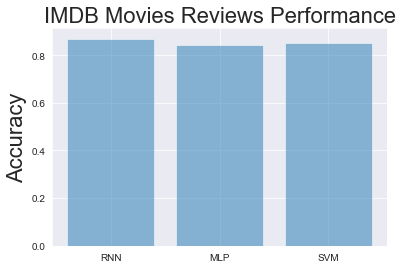

In [111]:
models_results_imdb = []
models_results_imdb.append(imdb_rnn_scores[1])
models_results_imdb.append(clf_mlp_imdb.score(data_imdb_X_test, data_imdb_Y_test))
models_results_imdb.append(clf_svm_imdb.score(data_imdb_X_test, data_imdb_Y_test))

labels = ["RNN", "MLP", "SVM"]
y_pos = np.arange(len(labels))
y_label = "Accuracy"

plt.bar(y_pos, models_results_imdb ,align="center",alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel(y_label, fontsize=22)
plt.title("IMDB Movies Reviews Performance", fontsize=22)

Text(0.5, 1.0, 'SPAM Text Messages Performance')

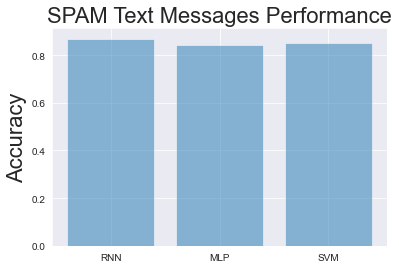

In [112]:
models_results_spam = []
models_results_spam.append(spam_rnn_scores[1])
models_results_spam.append(clf_mlp_spam.score(data_spam_X_test, data_spam_y_test))
models_results_spam.append(clf_svm_spam.score(data_spam_X_test, data_spam_y_test))

labels = ["RNN", "MLP", "SVM"]
y_pos = np.arange(len(labels))
y_label = "Accuracy"

plt.bar(y_pos, models_results_imdb ,align="center",alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel(y_label, fontsize=22)
plt.title("SPAM Text Messages Performance", fontsize=22)